# Problem 3 - Transfer learning: Shallow learning vs Finetuning

In this problem we will train a convolutional neural network for image classification using transfer learning. Transfer learning involves training a base network from scratch on a very large dataset (e.g., Imagenet1K with 1.2 M images and 1K categories) and then using this base network either as a feature extractor or as an initialization network for target task. Thus two major transfer learning scenarios are as follows:


• Finetuning the base model: Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on Imagenet dataset. Rest of the training looks as usual however the learning rate schedule for transfer learning may be different.

• Base model as fixed feature extractor: Here, we will freeze the weights for all of the network except that of the final fully connected layer. 

This last fully connected layer is replaced with a new one with random weights and only this layer is trained.
For this problem the following resources will be helpful.
References
• Pytorch blog. Transfer Learning for Computer Vision Tutorial by S. Chilamkurthy Available at https://pytorch.org/tutorials/beginner/transfer learning tutorial.html
• Notes on Transfer Learning. CS231n Convolutional Neural Networks for Visual Recognition. Available at https://cs231n.github.io/transfer-learning/
• Visual Domain Decathlon


1. For fine-tuning you will select a target dataset from the Visual-Decathlon challenge. Their web site (link below) has several datasets which you can download. Select any one of the visual decathlon dataset and make it your target dataset for transfer learning. Important : Do not select Imagenet1K as the target dataset.

In [1]:
import tensorflow_datasets as tfds
from torchvision import models,datasets,transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch 

stats = ((0.507, 0.487, 0.441), (0.267, 0.256, 0.276))

data_transforms = {
    'train': transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         transforms.RandomHorizontalFlip(), 
                         transforms.ToTensor(), 
                         transforms.Normalize(*stats,inplace=True)]),
    'val': transforms.Compose([
        transforms.ToTensor(),
         transforms.Normalize(*stats)

    ]),
}


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = {'train':datasets.CIFAR100(root='./data', train=True, download=True, 
transform=data_transforms['train']),
    "val":datasets.CIFAR100(root='./data', train=False, download=True, 
transform=data_transforms['val'])}



  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
batch_size = 64
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=3),
    'val': DataLoader(data['val'], batch_size=batch_size*2, shuffle=True,num_workers=3)
}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [3]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

(a) Finetuning: You will first load a pretrained model (Resnet50) and change the final fully connected layer output to the number of classes in the target dataset. Describe your target dataset features, number of classes and distribution of images per class (i.e., number of images per class). Show any 4 sample images (belonging to 2 different classes) from your target dataset. (2+2)

***Answer:***

The CIFAR-100 dataset contains 50,000 training and 10,000 test images of 20 object classes, along with 100 object subclasses. It is traditional to train on the 100 object subclasses. Each image is an RGB image of size 32x3

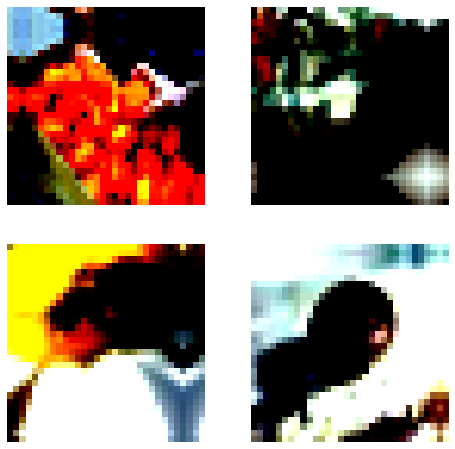

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np

figure = plt.figure(figsize=(8, 8))
cols, rows = 2, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataloaders['train']), size=(1,)).item()
    img, label = data['train'][sample_idx]
    figure.add_subplot(rows, cols, i)
    npimg = img.numpy()
    # plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [5]:
# pretrained model.
resnet = models.resnet50(pretrained=True)

num_features = resnet.fc.in_features

# the fully connected layer with to classify the 100 classes

resnet.fc = nn.Linear(num_features,100)

# sending to device , Following tutorial.
resnet.to(device)



/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

(b) First finetune by setting the same value of hyperparameters (learning rate=0.001, momentum=0.9) for all the layers. Keep batch size of 64 and train for 50-60 epochs or until model converges well. You will use a multi-step learning rate schedule and decay by a factor of 0.1 (γ = 0.1 in the link below). You can choose steps at which you want to decay the learning rate but do 3 drops during the training. So the first drop will bring down the learning rate to 0.0001, second to 0.00001, third to 0.000001. For example, if training for 60 epochs, first drop can happen at epoch 15, second at epoch 30 and third at epoch 45. (6)


In [6]:
import time
import os
import copy
dataset_sizes = {x: len(data[x]) for x in ['train', 'val']}
#dictiorany to store the data across epochs
training_data = {"epoch":[],'train_acc':[],"test_acc":[]}

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    training_data["epoch"] = []
    training_data['train_acc'] = []
    training_data["test_acc"] = []
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            training_data['epoch'].append(epoch+1)
            if phase =='train':
              training_data['train_acc'].append(epoch_acc)
            else:
              training_data['test_acc'].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
# Function created by me to print a 
def print_history(data):
  import matplotlib.pyplot as plt

  new_data  = {}
  for k, v in data.items():
    if k is not 'epoch':
      v = [ float(i.detach().to("cpu").numpy()) for i in v]
      new_data[k] = v

  plt.plot(list(set(data['epoch'])),new_data['train_acc'],label= "Training Accuracy")
  plt.plot(list(set(data['epoch'])),new_data['test_acc'],label= "Validation Accuracy")
  plt.legend()
  plt.show()

In [9]:
epochs = 40
step = 10

criterion = nn.CrossEntropyLoss()

# setting hyperparameter values.
optimizer = torch.optim.SGD(resnet.parameters(),lr = 0.001,momentum = 0.9)

# multistep learning rate schedule

step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step,gamma = 0.1)

model_1 = train_model(resnet, criterion, optimizer, step_lr_scheduler, num_epochs=epochs)


Epoch 0/39
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 2.9548 Acc: 0.2898
val Loss: 1.9814 Acc: 0.4641

Epoch 1/39
----------
train Loss: 1.9181 Acc: 0.4783
val Loss: 1.6577 Acc: 0.5355

Epoch 2/39
----------
train Loss: 1.6387 Acc: 0.5459
val Loss: 1.5349 Acc: 0.5685

Epoch 3/39
----------
train Loss: 1.4644 Acc: 0.5889
val Loss: 1.4684 Acc: 0.5906

Epoch 4/39
----------
train Loss: 1.3330 Acc: 0.6201
val Loss: 1.4436 Acc: 0.5947

Epoch 5/39
----------
train Loss: 1.2276 Acc: 0.6457
val Loss: 1.3929 Acc: 0.6105

Epoch 6/39
----------
train Loss: 1.1320 Acc: 0.6726
val Loss: 1.3875 Acc: 0.6098

Epoch 7/39
----------
train Loss: 1.0632 Acc: 0.6871
val Loss: 1.3645 Acc: 0.6251

Epoch 8/39
----------
train Loss: 0.9867 Acc: 0.7114
val Loss: 1.3600 Acc: 0.6242

Epoch 9/39
----------
train Loss: 0.9250 Acc: 0.7247
val Loss: 1.3378 Acc: 0.6325

Epoch 10/39
----------
train Loss: 0.7552 Acc: 0.7746
val Loss: 1.2690 Acc: 0.6508

Epoch 11/39
----------
train Loss: 0.7073 Acc: 0.7890
val Loss: 1.2606 Acc: 0.6514

Epoch 12/39
----------
t

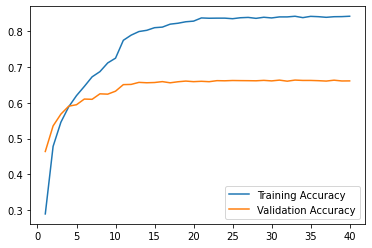

In [12]:
print_history(training_data)



(c) Next keeping all the hyperparameters (including multi-step learning rate schedule) same as before, change the learning rate to 0.01 and 0.1 uniformly for all the layers. This means keep all the layers at same learning rate. So you will be doing two experiments, one keeping learning rate of all layers at 0.01 and one with 0.1. Again finetune the model and report the final accuracy. How does the accuracy with the three learning rates compare ? Which learning rate gives you the best accuracy on the target dataset ? 

In [ ]:
# experiment with initial learning rate of 0.1
resnet = models.resnet50(pretrained=True)

num_features = resnet.fc.in_features

# the fully connected layer with to classify the 100 classes

resnet.fc = nn.Linear(num_features,100)

# sending to device , Following tutorial.
resnet.to(device)

# learning rate to 0.01
optimizer = torch.optim.SGD(resnet.parameters(),lr = 0.1,momentum = 0.9)

# multistep learning rate schedule

step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step,gamma = 0.1)

model_2 = train_model(resnet, criterion, optimizer, step_lr_scheduler, num_epochs=epochs)


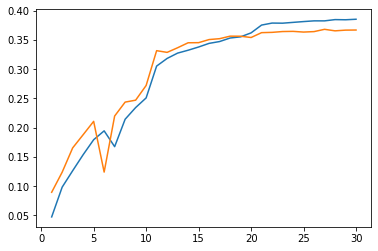

In [ ]:
print_history(training_data)

In [ ]:
# experiment with initial learning rate of 0.01
resnet = models.resnet50(pretrained=True)

num_features = resnet.fc.in_features

# the fully connected layer with to classify the 100 classes

resnet.fc = nn.Linear(num_features,100)

# sending to device , Following tutorial.
resnet.to(device)

# learning rate to 0.01
optimizer = torch.optim.SGD(resnet.parameters(),lr = 0.01,momentum = 0.9)

# multistep learning rate schedule

step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step,gamma = 0.1)

model_3 = train_model(resnet, criterion, optimizer, step_lr_scheduler, num_epochs=epochs)

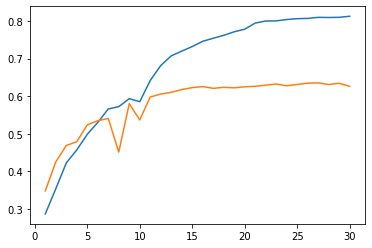

In [ ]:
print_history(training_data)

2. When using a pretrained model as feature extractor, all the layers of the network are frozen except the final layer. Thus except the last layer, none of the inner layers’ gradients are updated during backward pass with the target dataset. Since gradients do not need to be computed for most of the network, this is faster than finetuning.

(a) Now train only the last layer for 1, 0.1, 0.01, and 0.001 while keeping all the other hyperparameters and settings same as earlier for finetuning. Which learning rate gives you the best accuracy on the target dataset ? (6)

In [ ]:
# freeze resnet weights
# start with lr =1

epochs = 40
step = 10

resnet = models.resnet50(pretrained=True)


for param in resnet.parameters():
    param.requires_grad = False


num_features = resnet.fc.in_features

# the fully connected layer with to classify the 100 classes

resnet.fc = nn.Linear(num_features,100)

# sending to device , Following tutorial.
resnet.to(device)

# learning rate to 0.01
optimizer = torch.optim.SGD(resnet.parameters(),lr = 1,momentum = 0.9)

# multistep learning rate schedule

step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step,gamma = 0.1)

model_4 = train_model(resnet, criterion, optimizer, step_lr_scheduler, num_epochs=epochs)


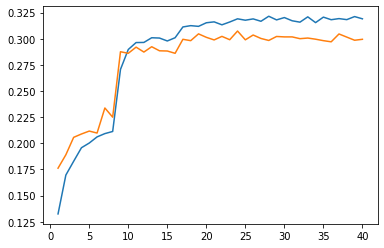

In [ ]:
print_history(training_data)

In [ ]:
#frozen weights 
#initial lr = 0.1

resnet = models.resnet50(pretrained=True)


for param in resnet.parameters():
    param.requires_grad = False


num_features = resnet.fc.in_features

# the fully connected layer with to classify the 100 classes

resnet.fc = nn.Linear(num_features,100)

# sending to device , Following tutorial.
resnet.to(device)

# learning rate to 0.01
optimizer = torch.optim.SGD(resnet.parameters(),lr = 0.1,momentum = 0.9)

# multistep learning rate schedule

step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step,gamma = 0.1)

model_5 = train_model(resnet, criterion, optimizer, step_lr_scheduler, num_epochs=epochs)

{1, 2, 3, 4, 5, 6, 7, 8}

In [ ]:
#frozen weights 
#initial lr =  0.01

resnet = models.resnet50(pretrained=True)


for param in resnet.parameters():
    param.requires_grad = False


num_features = resnet.fc.in_features

# the fully connected layer with to classify the 100 classes

resnet.fc = nn.Linear(num_features,100)

# sending to device , Following tutorial.
resnet.to(device)

# learning rate to 0.01
optimizer = torch.optim.SGD(resnet.parameters(),lr = 0.01,momentum = 0.9)

# multistep learning rate schedule

step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step,gamma = 0.1)

model_6 = train_model(resnet, criterion, optimizer, step_lr_scheduler, num_epochs=epochs)

In [ ]:
#frozen weights 
#initial lr =  0.01

resnet = models.resnet50(pretrained=True)


for param in resnet.parameters():
    param.requires_grad = False


num_features = resnet.fc.in_features

# the fully connected layer with to classify the 100 classes

resnet.fc = nn.Linear(num_features,100)

# sending to device , Following tutorial.
resnet.to(device)

# learning rate to 0.01
optimizer = torch.optim.SGD(resnet.parameters(),lr = 0.001,momentum = 0.9)

# multistep learning rate schedule

step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step,gamma = 0.1)

model_7 = train_model(resnet, criterion, optimizer, step_lr_scheduler, num_epochs=epochs)

(b) For your target dataset find the best final accuracy (across all the learning rates) from the two transfer learning approaches. Which approach and learning rate is the winner? Provide a plausible explanation to support your observation